In [1]:
# From
# https://colab.research.google.com/github/dattalab/keypoint-moseq/blob/main/docs/keypoint_moseq_colab.ipynb

In [1]:
import keypoint_moseq as kpms
import numpy as np
from pathlib import Path

In [2]:
# Input data - if SLEAP, it needs to be SLEAP H5 FILE
# data_dir='/home/sminano/swc/project_teaching_behaviour/mouse-EPM/derivatives/behav/software-SLEAP_project/predictions/video-1.predictions.slp'
# sleap_file='video-1.predictions.slp'
# sleap_file = os.path.join(data_dir, sleap_file) 
# sleap_predictions = '/home/sminano/swc/project_teaching_behaviour/mouse-EPM/derivatives/behav/software-SLEAP_project/predictions/video-1.predictions.slp'
video_path = (
    Path().cwd().parents[1] /
    "mouse-EPM" /
    "rawdata" /
    "sub-01_id-M708149" /
    "ses-01_date-20200317"/
    "behav"/ 
    "video-1.mp4"  # sub-01_ses-01_task-EPM_time-165049_
)
sleap_predictions = (
    Path().cwd().parents[1] /
    "mouse-EPM" /
    "derivatives"/
    "behav"/
    "software-SLEAP_project"/
    "predictions"/
    "video-1.predictions.analysis.h5"
)
# sleap_predictions = '/home/sminano/swc/project_teaching_behaviour/mouse-EPM/derivatives/behav/software-SLEAP_project/predictions/video-1.predictions.analysis.h5'


In [3]:
# Create moseq project
project_dir = '/home/sminano/swc/project_teaching_behaviour/mouse-EPM-moseq-video-1' # must not exist before
config = lambda: kpms.load_config(project_dir)

# use SLEAP predictions file
kpms.setup_project(project_dir, sleap_file=sleap_predictions) # this creates a config file

The directory `/home/sminano/swc/project_teaching_behaviour/mouse-EPM-
moseq-video-1` already exists. Use `overwrite=True` or pick a
different name


In [4]:
# Edit config
kpms.update_config(
    project_dir,
    video_dir=str(Path(video_path).parent),
    anterior_bodyparts=['snout', 'left_ear', 'right_ear'],  # used to initialize heading
    posterior_bodyparts=['tail_base'], # used to initialize heading
    # use_bodyparts= # determines the subset of bodyparts to use for modeling and the order in which they are represented
)

In [5]:
# Load keypoints and preprocess
coordinates, confidences, bodyparts = kpms.load_keypoints(str(sleap_predictions), 'sleap')

# - coordinates: for each video, an array of size (nframes, n_kpts, n_spatial_dims) with the coords of the keypoints in image coord system
# - confidences: for each video, an array of size (nframes, n_kpts)

Loading keypoints: 100%|██████████████████| 1/1 [00:00<00:00, 45.65it/s]


In [6]:
############# Viz ############################

In [55]:
coordinates['video-1.predictions.analysis'].shape

(18485, 6, 2)

Text(0, 0.5, 'y (pixels)')

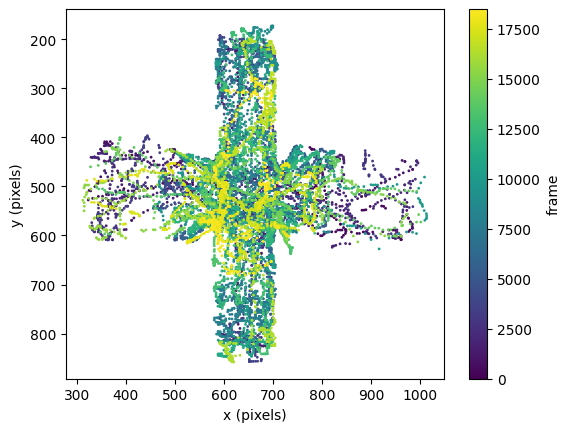

In [43]:
import matplotlib.pyplot as plt

coords = coordinates['video-1.predictions.analysis']

# trajectory of first kpt in time
fig, ax = plt.subplots(1,1)
im = ax.scatter(
    x=coords[:,0,0],  # first kpt
    y=coords[:,0,1],  # first kpt
    s=1,
    c=range(coords.shape[0]),
    vmin=0,
    vmax=coords.shape[0]
)

# Add a colorbar based on the scatter plot
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('frame')  # Optional: label for the colorbar
ax.set_aspect("equal")
ax.set_xlabel("x (pixels)")
ax.set_ylabel("y (pixels)")
ax.invert_yaxis()


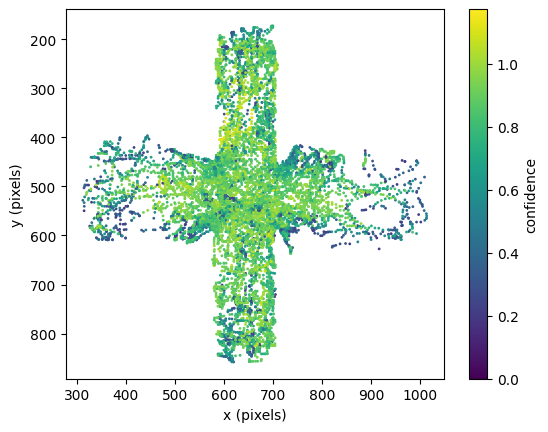

In [48]:
# color by confidence

# trajectory of first kpt in time
fig, ax = plt.subplots(1,1)
im = ax.scatter(
    x=coords[:,0,0],  # first kpt
    y=coords[:,0,1],  # first kpt
    s=1,
    c=confidences['video-1.predictions.analysis'][:,0], # first kpt
    vmin=np.nanmin(confidences['video-1.predictions.analysis'][:,0]),
    vmax=np.nanmax(confidences['video-1.predictions.analysis'][:,0])
)

# Add a colorbar based on the scatter plot
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('confidence')  # Optional: label for the colorbar
ax.set_aspect("equal")
ax.set_xlabel("x (pixels)")
ax.set_ylabel("y (pixels)")
ax.invert_yaxis()


In [ ]:
#########################################

In [7]:
# format data for modeling
data, metadata = kpms.format_data(coordinates, confidences, **config())

print(data.keys())
print(metadata)

dict_keys(['Y', 'conf', 'mask'])
(array(['video-1.predictions.analysis', 'video-1.predictions.analysis'],
      dtype='<U28'), array([[    0, 10030],
       [10000, 18485]]))


>=90.0% of variance exlained by 3 components.


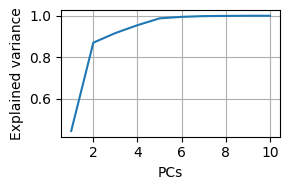

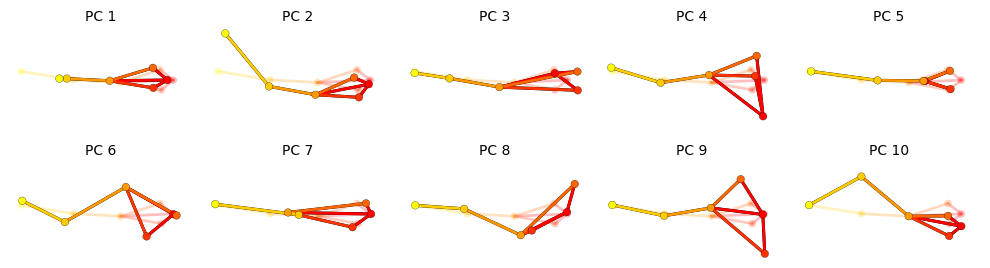

In [8]:
# Calibration regression --- skipped

# Fit PCA
pca = kpms.fit_pca(**data, **config())

kpms.save_pca(pca, project_dir)  # saves it to the project

# visualise results
kpms.print_dims_to_explain_variance(pca, 0.9)
kpms.plot_scree(pca, project_dir=project_dir)
kpms.plot_pcs(pca, project_dir=project_dir, **config())

# save number of dimensions to keep
kpms.update_config(project_dir, latent_dim=4)

In [9]:
# Overview model fitting
# 1. Random initialisation
# 2. Fit an AR-HMM
# 3. Fit full model
# 4. Extract model results

# Setting kappa


In [10]:
# 1. Randomly initialize the model
model = kpms.init_model(data, pca=pca, **config())

print(model.keys())

# optionally modify kappa
# model = kpms.update_hypparams(model, kappa=NUMBER)

dict_keys(['seed', 'hypparams', 'noise_prior', 'params', 'states'])


In [14]:
model["hypparams"]

{'trans_hypparams': {'alpha': 5.7,
  'gamma': 1000.0,
  'kappa': 1000000.0,
  'num_states': 100},
 'ar_hypparams': {'K_0_scale': 10.0,
  'S_0_scale': 0.01,
  'latent_dim': 4,
  'nlags': 3,
  'S_0': DeviceArray([[0.01, 0.  , 0.  , 0.  ],
               [0.  , 0.01, 0.  , 0.  ],
               [0.  , 0.  , 0.01, 0.  ],
               [0.  , 0.  , 0.  , 0.01]], dtype=float64),
  'K_0': DeviceArray([[10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
                 0.],
               [ 0., 10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
                 0.],
               [ 0.,  0., 10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
                 0.],
               [ 0.,  0.,  0., 10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
                 0.],
               [ 0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
                 0.],
               [ 0.,  0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  0.,  0.,  0.,
                 0.],
               [ 0.,  0.,  0

In [11]:
model['states'].keys()
# ---> dict_keys(['z', 'x', 'v', 'h', 's'])
# - syllable labels (z)
# - inferred low-dim pose state (x)
# - inferred centroid (v)
# - inferred heading (h)
#     ⋮
# ```

dict_keys(['z', 'x', 'v', 'h', 's'])

In [12]:
!nvidia-smi

Thu Sep 12 17:28:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4080        Off | 00000000:01:00.0 Off |                  N/A |
| 31%   39C    P2              46W / 320W |  14600MiB / 16376MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Outputs will be saved to
/home/sminano/swc/project_teaching_behaviour/mouse-EPM-moseq-
video-1/2024_09_12-17_28_54


 25%|████████▍                         | 25/101 [00:24<01:10,  1.08it/s]

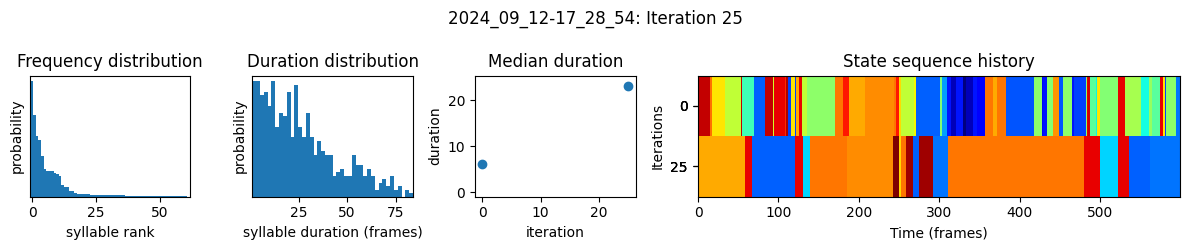

 50%|████████████████▊                 | 50/101 [00:48<00:47,  1.08it/s]

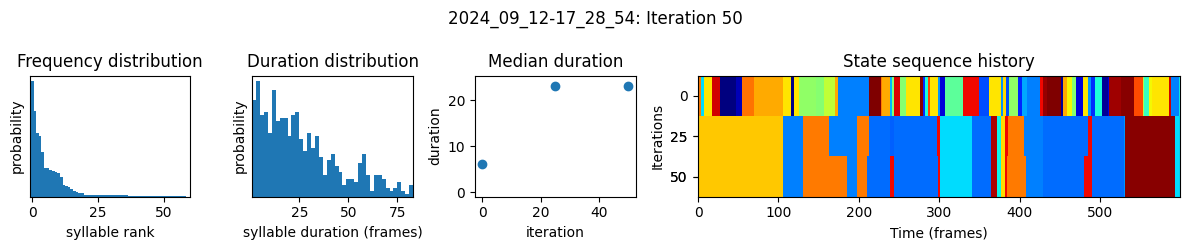

 74%|█████████████████████████▏        | 75/101 [01:11<00:24,  1.08it/s]

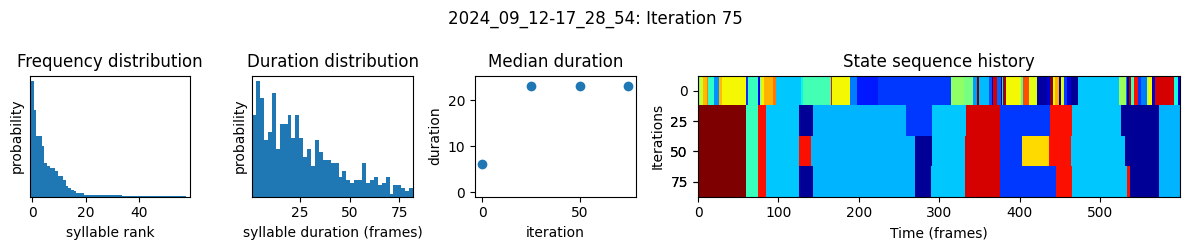

 99%|████████████████████████████████▋| 100/101 [01:35<00:00,  1.08it/s]

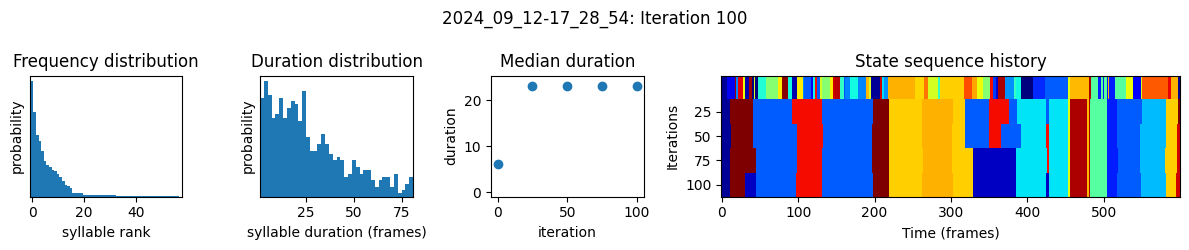

100%|█████████████████████████████████| 101/101 [01:36<00:00,  1.05it/s]


In [13]:
# 2. Fit AR-HMM
num_ar_iters = 100

model, model_name = kpms.fit_model(
    model, 
    data, 
    metadata, 
    project_dir,
    ar_only=True, 
    num_iters=num_ar_iters
)

In [ ]:
# How can I check the median syllable duration? ---------

Outputs will be saved to
/home/sminano/swc/project_teaching_behaviour/mouse-EPM-moseq-
video-1/2024_09_12-16_18_58


  0%|                                           | 0/501 [00:00<?, ?it/s]

  5%|█▋                                | 25/501 [00:35<07:51,  1.01it/s]

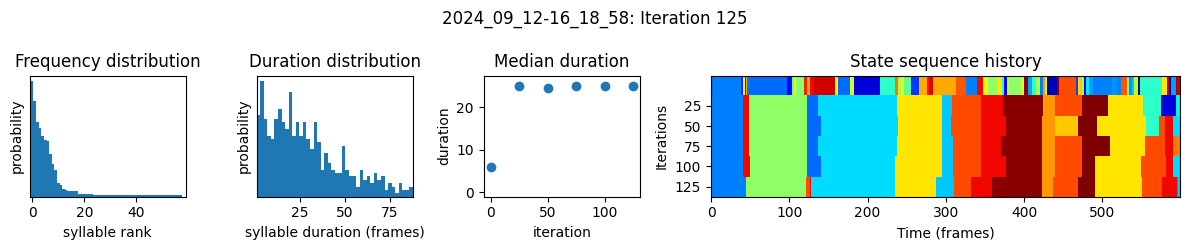

 10%|███▍                              | 50/501 [01:00<07:25,  1.01it/s]

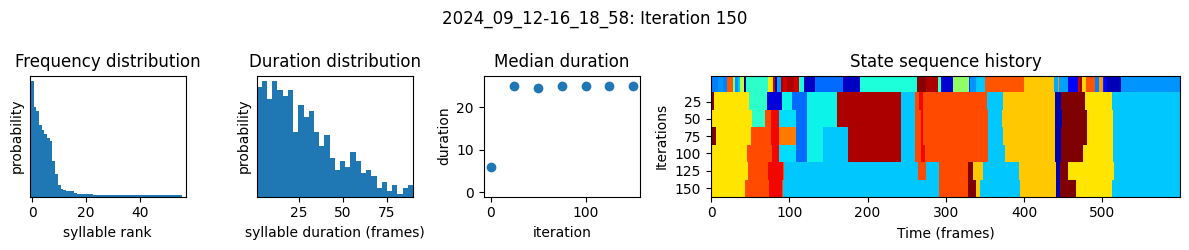

 15%|█████                             | 75/501 [01:24<07:00,  1.01it/s]

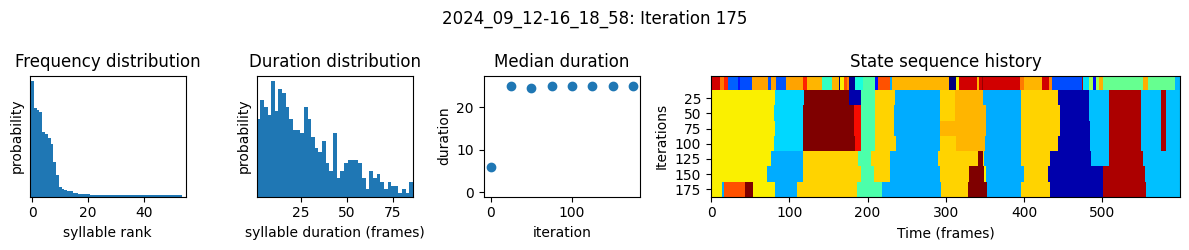

 20%|██████▌                          | 100/501 [01:49<06:35,  1.01it/s]

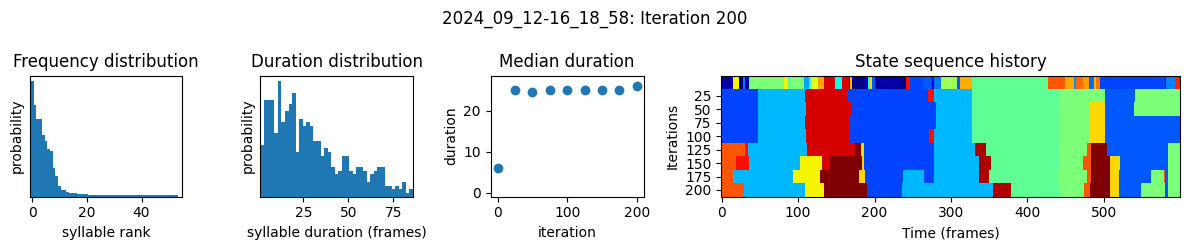

 25%|████████▏                        | 125/501 [02:14<06:11,  1.01it/s]

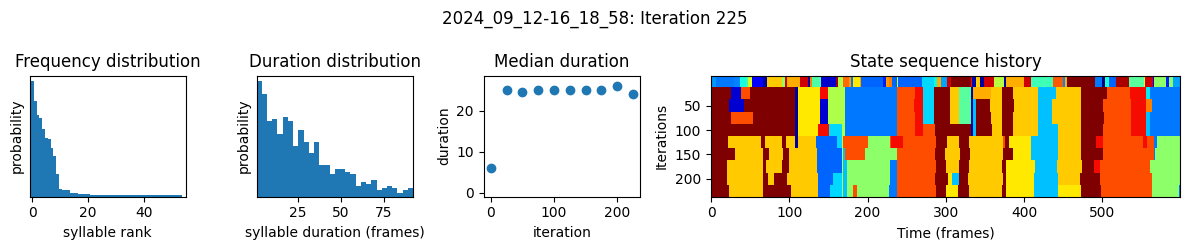

 30%|█████████▉                       | 150/501 [02:39<05:46,  1.01it/s]

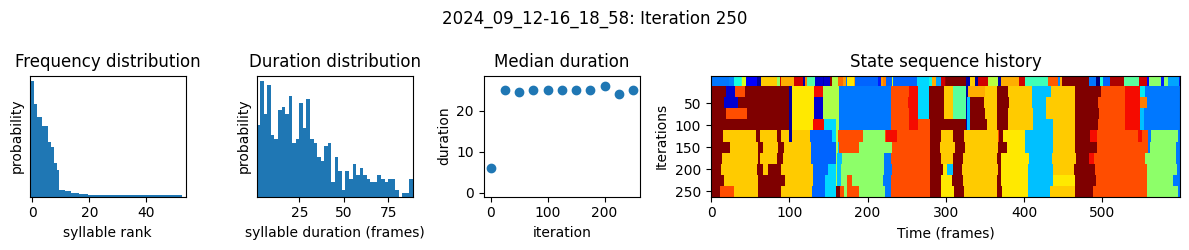

 35%|███████████▌                     | 175/501 [03:04<05:21,  1.01it/s]

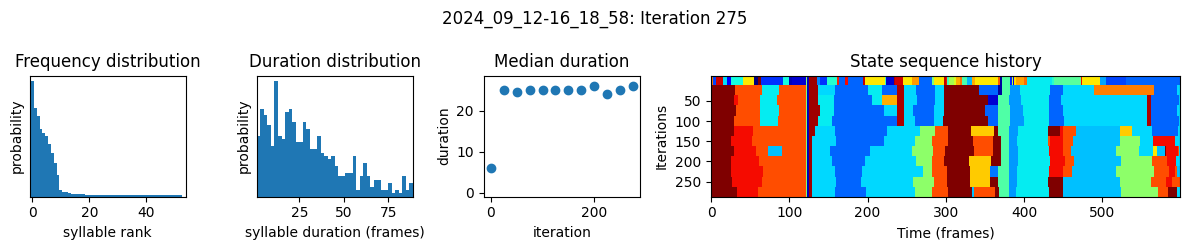

 40%|█████████████▏                   | 200/501 [03:29<04:56,  1.01it/s]

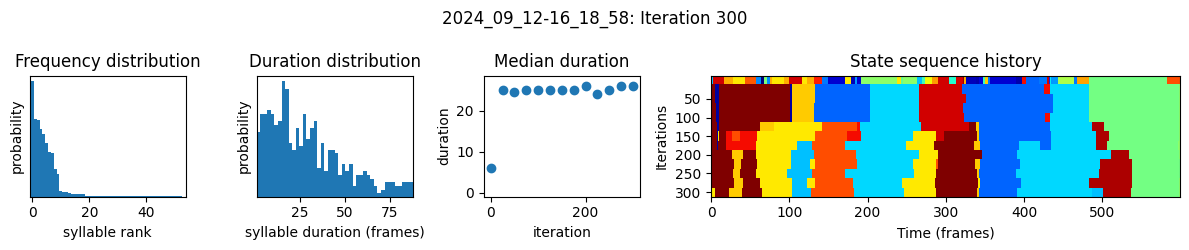

 45%|██████████████▊                  | 225/501 [03:54<04:32,  1.01it/s]

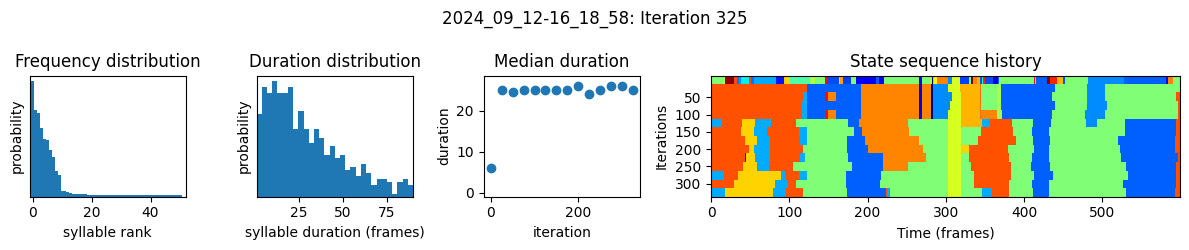

 50%|████████████████▍                | 250/501 [04:19<04:07,  1.01it/s]

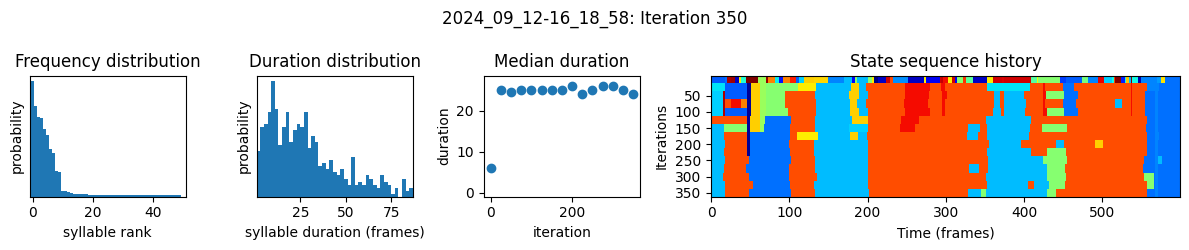

 55%|██████████████████               | 275/501 [04:44<03:43,  1.01it/s]

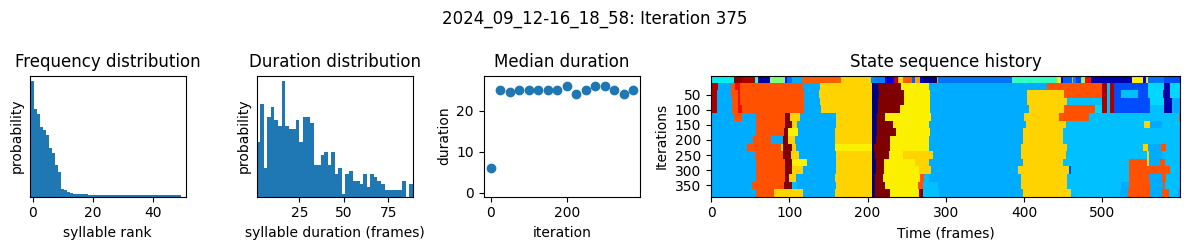

 60%|███████████████████▊             | 300/501 [05:09<03:18,  1.01it/s]

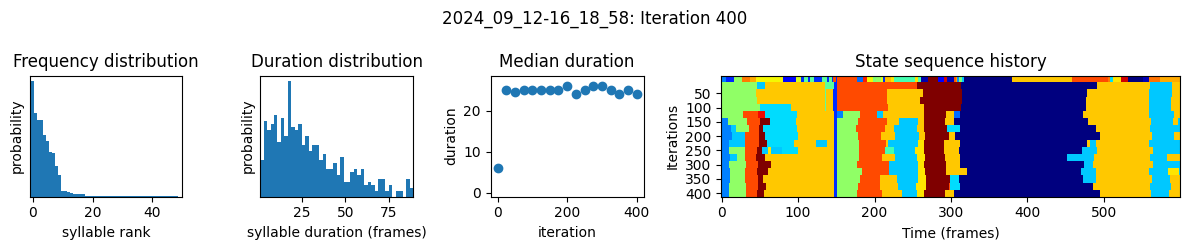

 65%|█████████████████████▍           | 325/501 [05:34<02:53,  1.01it/s]

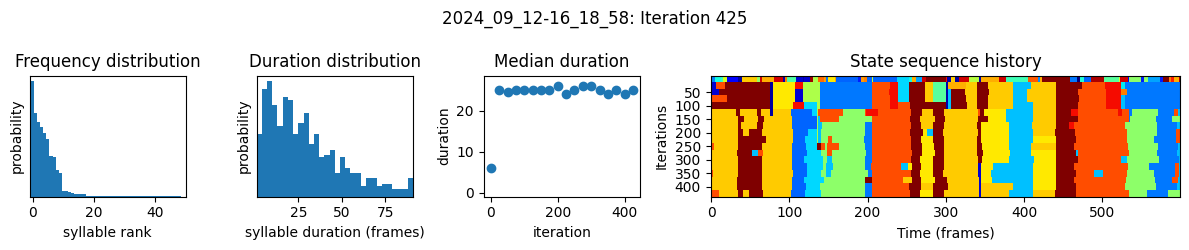

 70%|███████████████████████          | 350/501 [05:58<02:29,  1.01it/s]

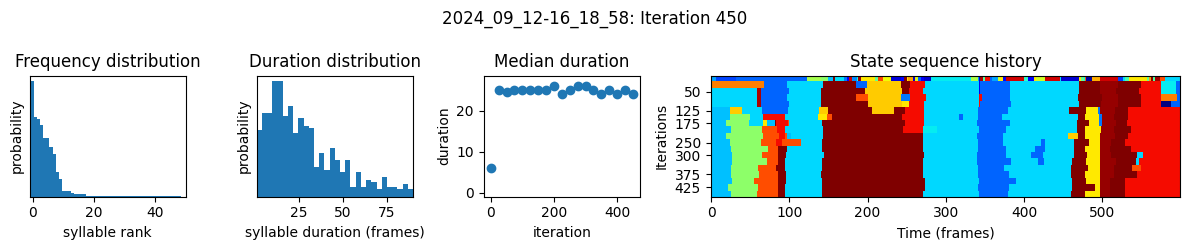

 75%|████████████████████████▋        | 375/501 [06:23<02:04,  1.01it/s]

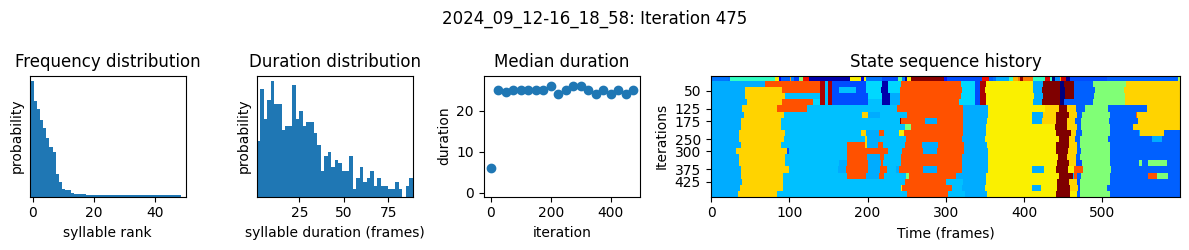

 80%|██████████████████████████▎      | 400/501 [06:48<01:39,  1.01it/s]

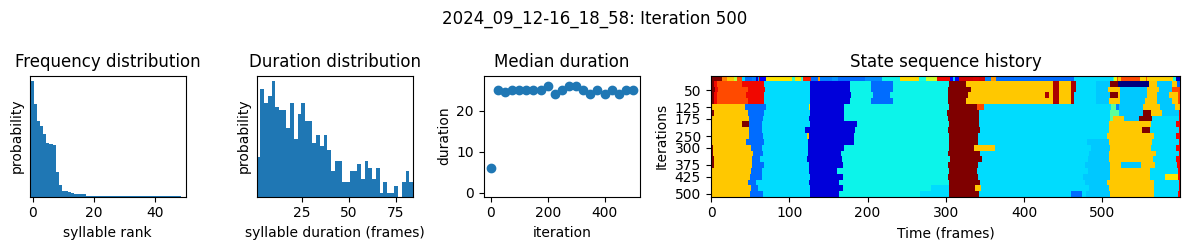

 85%|███████████████████████████▉     | 425/501 [07:13<01:15,  1.01it/s]

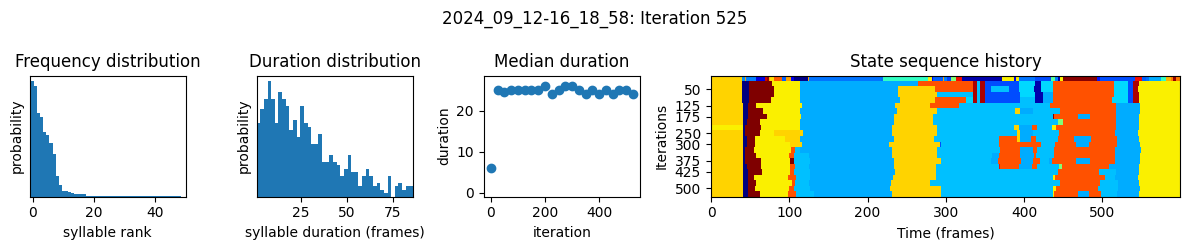

 90%|█████████████████████████████▋   | 450/501 [07:38<00:50,  1.01it/s]

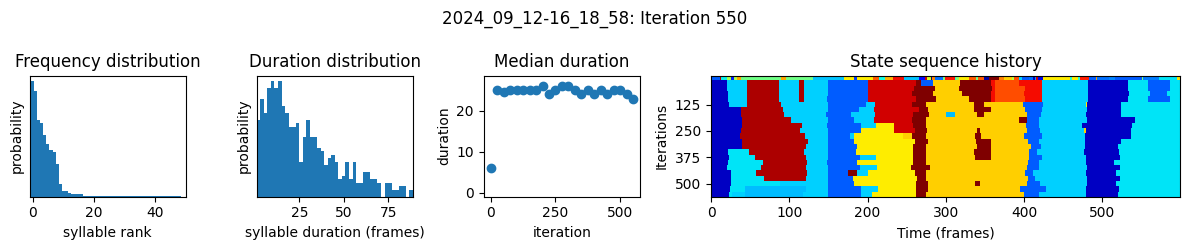

 95%|███████████████████████████████▎ | 475/501 [08:03<00:25,  1.01it/s]

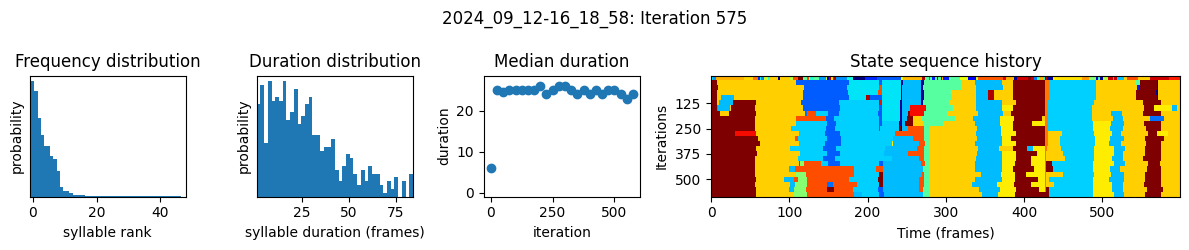

100%|████████████████████████████████▉| 500/501 [08:28<00:00,  1.01it/s]

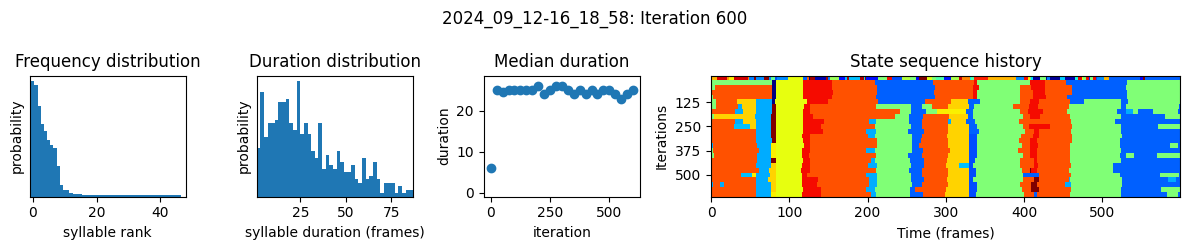

100%|█████████████████████████████████| 501/501 [08:29<00:00,  1.02s/it]


In [75]:
# 3. Fit full model
# You may need to try a few values of kappa

# load model checkpoint
model, data, metadata, current_iter = kpms.load_checkpoint(
    project_dir, model_name, iteration=num_ar_iters
)

# modify kappa to maintain the desired syllable time-scale
model = kpms.update_hypparams(model, kappa=1e4)

# run fitting for an additional 500 iters
model = kpms.fit_model(
    model, data, metadata, project_dir, model_name, ar_only=False, 
    start_iter=current_iter, num_iters=current_iter+500
)[0]
    

In [77]:
# 4. Extract model results
# Parse the modeling results and save them to `{project_dir}/{model_name}/results.h5`. 
# The results are stored as follows, and can be reloaded at a later time using `kpms.load_results`. 
# Check the docs for an [in-depth explanation of the modeling results](https://keypoint-moseq.readthedocs.io/en/latest/FAQs.html#interpreting-model-outputs).
# ```
#     results.h5
#     ├──recording_name1
#     │  ├──syllable      # syllable labels (z)
#     │  ├──latent_state  # inferred low-dim pose state (x)
#     │  ├──centroid      # inferred centroid (v)
#     │  └──heading       # inferred heading (h)
#     ⋮
# ```

# modify a saved checkpoint so syllables are ordered by frequency
kpms.reindex_syllables_in_checkpoint(project_dir, model_name)

# load the most recent checkpoint
model, data, metadata, current_iter = kpms.load_checkpoint(project_dir, model_name)

# extract results ---- what are the results?
results = kpms.extract_results(model, metadata, project_dir, model_name)

# optionally save results as csv
kpms.save_results_as_csv(results, project_dir, model_name)

Reindexing: 100%|██████████| 25/25 [00:00<00:00, 210.21model snapshot/s]


Saved results to /home/sminano/swc/project_teaching_behaviour/mouse-
EPM-moseq-video-1/2024_09_12-16_18_58/results.h5


Saving to csv: 100%|██████████████████████| 1/1 [00:00<00:00, 21.32it/s]


In [93]:
results['video-1.predictions.analysis'].keys()

dict_keys(['syllable', 'latent_state', 'centroid', 'heading'])

In [90]:
######### Count freq of syllables across all video
syllables_per_frame = results['video-1.predictions.analysis']['syllable']  # array (nframes, )
syllables_count = {}
for syl in np.unique(syllables_per_frame):
    syllables_count[syl] = sum(syl == syllables_per_frame)

# sort
syllables_count = dict(sorted(syllables_count.items(), key=lambda item: item[1], reverse=True))

# print top 10
n_frames = results['video-1.predictions.analysis']['syllable'].shape[0]
n_frames
for syl, count in list(syllables_count.items())[:10]:
    print(f'Syllable id-{syl}: {count/100} % of frames')



{1: 3165, 0: 2952, 5: 2010, 4: 2002, 3: 1870, 2: 1654, 6: 1423, 7: 1317, 8: 599, 9: 231, 10: 205, 34: 158, 11: 122, 43: 110, 39: 87, 18: 67, 22: 66, 33: 60, 13: 54, 40: 51, 14: 37, 32: 33, 36: 31, 37: 24, 27: 21, 30: 20, 21: 17, 45: 17, 41: 13, 12: 9, 16: 9, 31: 8, 15: 6, 44: 6, 20: 4, 23: 4, 25: 4, 26: 3, 29: 3, 38: 3, 42: 3, 24: 2, 17: 1, 19: 1, 28: 1, 35: 1, 46: 1}
Syllable id-1: 31.65 % of frames
Syllable id-0: 29.52 % of frames
Syllable id-5: 20.1 % of frames
Syllable id-4: 20.02 % of frames
Syllable id-3: 18.7 % of frames
Syllable id-2: 16.54 % of frames
Syllable id-6: 14.23 % of frames
Syllable id-7: 13.17 % of frames
Syllable id-8: 5.99 % of frames
Syllable id-9: 2.31 % of frames


Median syllable duration (frames): 18.0
Median syllable duration (ms): 600.0


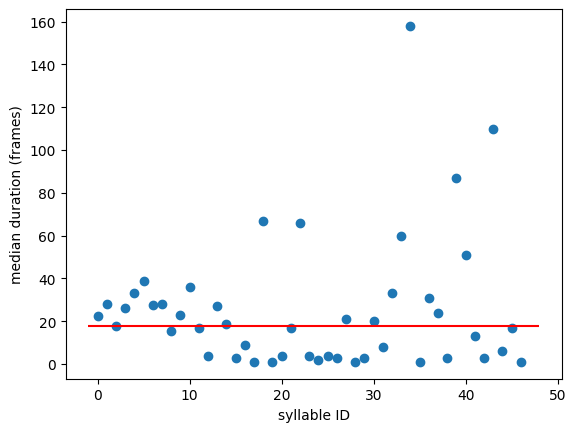

In [110]:
######### Count median duration per syllable
import itertools

# find lengths of continuous tracks
# itertools.groupby: generates a break or new group 
# every time the value of the key function changes
syllables_per_frame_len = [
    (key, len(list(group_iter)))
    for key, group_iter in itertools.groupby(syllables_per_frame)
]  # list of (syllable_id, len)

# compute median duration per syllable ID
median_duration_per_syl = {}
for syl in list(syllables_count.keys()):
    median_duration_per_syl[syl] = np.median(
        [
            syl_dur 
            for (syl_id, syl_dur) in syllables_per_frame_len 
            if syl_id==syl
        ]
    )  # frames

# plot
fps = 30 # fps

fig, ax = plt.subplots(1,1)
ax.scatter(
    x=median_duration_per_syl.keys(),
    y=median_duration_per_syl.values(),
)
ax.hlines(
    y=np.median(list(median_duration_per_syl.values())),
    xmin=-1,
    xmax=len(median_duration_per_syl)+1,
    colors='r'
)
ax.set_xlabel('syllable ID')
ax.set_ylabel('median duration (frames)')

print(f"Median syllable duration (frames): {np.median(list(median_duration_per_syl.values()))}")
print(f"Median syllable duration (ms): {1000*np.median(list(median_duration_per_syl.values()))/fps}")

Saving trajectory plots to /home/sminano/swc/project_teaching_behaviour/mouse-EPM-moseq/2024_08_16-15_21_45/trajectory_plots


Generating trajectory plots: 100%|████████| 5/5 [00:00<00:00,  5.47it/s]


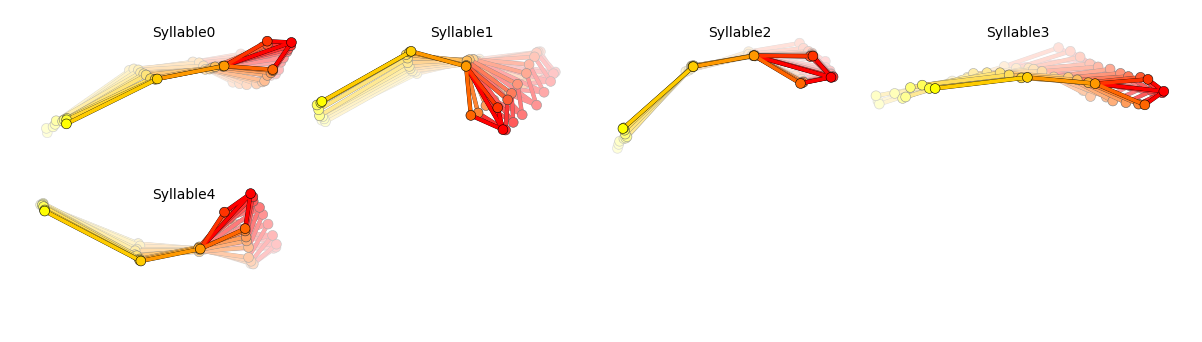

In [31]:
# Trajectory plots per syllable
results = kpms.load_results(project_dir, model_name)
kpms.generate_trajectory_plots(coordinates, results, project_dir, model_name, **config())

In [76]:
# Other viz:

# Grid movies
# kpms.generate_grid_movies(results, project_dir, model_name, coordinates=coordinates, **config());

# Syllable dendrogram
# kpms.plot_similarity_dendrogram(coordinates, results, project_dir, model_name, **config())

In [111]:
# Apply to new data (inference)
## Apply to new data

# The code below shows how to apply a trained model to new data. 
# This is useful if you have performed new experiments and would like 
# to maintain an existing set of syllables. The results for the new 
# experiments will be added to the existing `results.h5` file. 

# load the most recent model checkpoint and pca object
model = kpms.load_checkpoint(project_dir, model_name)[0]

# load new data (e.g. from deeplabcut)
new_data = '/home/sminano/swc/project_teaching_behaviour/mouse-EPM/derivatives/behav/software-SLEAP_project/predictions/video-2.predictions.analysis.h5' # can be a file, a directory, or a list of files
coordinates, confidences, bodyparts = kpms.load_keypoints(str(new_data), 'sleap')

# format data for model
data, metadata = kpms.format_data(coordinates, confidences, **config())

# apply saved model to new data
results = kpms.apply_model(
    model, 
    data, 
    metadata, 
    project_dir, 
    model_name, 
    **config()
) # ----> should add results to results.h5 file

# optionally rerun `save_results_as_csv` to export the new results
kpms.save_results_as_csv(results, project_dir, model_name)

Applying model: 100%|█████████████████| 500/500 [07:47<00:00,  1.07it/s]


Saved results to /home/sminano/swc/project_teaching_behaviour/mouse-
EPM-moseq-video-1/2024_09_12-16_18_58/results.h5


Saving to csv: 100%|██████████████████████| 1/1 [00:00<00:00, 32.52it/s]


In [112]:
results.keys()

dict_keys(['video-2.predictions.analysis'])